## Problem description
We want to solve the problem:
\begin{align}
\textrm{minimize} \quad f(x)=\textrm{max}_{i=1,\ldots,m}(a_i^T x+b_i),
\end{align}
where $x \in \mathbb{R}^n$ is the decision variable. First, we generate the problem instance.

In [109]:
n=20
m=100
A=randn(m,n)
b=randn(m,1)

100x1 Array{Float64,2}:
  0.142087  
  0.374105  
 -0.173977  
 -0.885369  
 -1.12417   
 -1.3783    
 -1.01133   
  0.611571  
 -0.558535  
  0.3998    
  0.399038  
 -0.676528  
 -0.0279316 
  ⋮         
 -0.185177  
 -0.50311   
 -0.523922  
  0.148922  
  0.00513859
 -0.0691724 
  0.601211  
  0.368494  
 -1.09572   
  0.292353  
  1.68052   
  0.232486  

## Solving the problem using interior point algorithm (using `Convex.jl`)
Now we compute the optimal value by solving the problem using `Convex.jl`. Note that $\textrm{max}_{i=1,\ldots,m}(a_i^T x+ b_i)=\textrm{max}{(A x+ b)}$, where $A=\left( \begin{array}{c}
a_1^T \\
\vdots \\
a_m^T \end{array} \right) 
$
and $b= \left( \begin{array}{c} b_1 \\ \vdots \\ b_m \end{array} \right)$. In `Convex`, we can represent the objective function as `maximum(A*x-b)`.

In [110]:
# Pkg.add("Convex") # Run this command if you do not have Convex.jl

In [111]:
# Pkg.add("SCS") # This is our solver, install this if you do not have this 

In [112]:
using Convex

In [113]:
using SCS

In [114]:
xMin=Variable(n) # Defining the variable

Variable of
size: (20, 1)
sign: NoSign()
vexity: AffineVexity()

In [115]:
problem=minimize(maximum(A*xMin-b)) # Defining the problem

solve!(problem,SCSSolver()) # Solve the problem using SCS solver

print(
"The status of the solution is ", problem.status, 
"\nwith optimal objective value, f(x*)=", problem.optval, 
"\nand optimal solution, x*=\n ", xMin.value
)

xMinValue=xMin.value
fMinValue=problem.optval

The status of the solution is Optimal
with optimal objective value, f(x*)=1.237806138131535
and optimal solution, x*=
 [-0.07325494121495157
 0.2915263523027921
 0.09284525020305326
 0.3233267680963541
 0.26243405670476405
 -0.03781453573656068
 0.03832558885749013
 0.01850278872458355
 0.1372138051797083
 0.06537967184622627
 -0.44892028620362134
 0.2339202017627254
 -0.06432852121940598
 0.3357368797049172
 -0.0331755950343309
 0.38633240419450726
 0.17612229357210693
 -0.05592574968681078
 -0.06796876347828842
 -0.23765351332500387]

1.237806138131535

## Subgradient method in one line
The subgradient method can be described in one line, which is as follows: 

\begin{align}
\forall k \in \{0,1,\ldots\} \quad x^{(k+1)}=x^{(k)}-\alpha_k g^{(k)}, \qquad \qquad (1)
\end{align}

where $\alpha_k$ is the step size, and $g^{k}$ is a subgradient of the objective function at $x^{(k)}$. For our case, $g^{(k)}$ can be calculated as follows. At first we find an index $\bar{i}$ such that $a_\bar{i}^T x+b_\bar{i}$ which is active at $f(x^{(k)})$, i.e., $f(x^{(k)})=a_\bar{i}^T x^{(k)} + b_\bar{i}$, then $g^{k}=a_\bar{i}$. There are different step size rules, at first we are going to consider constant step length.

## Implementing subgradient method for constant step length
Let us write a `function` in Julia that will implement subgradient method for the piecewise linear problem with constant step length. Here we set $\alpha^{k}=\gamma / \|g^{(k)}\|_2 $. So  Equation (1) can be written as:


\begin{align}
\forall k \in \{1,2,\ldots\} \quad x^{(k+1)}=x^{(k)}-\gamma/\|g^{(k)}\|_2 a_\bar{i}. \quad \qquad (2)
\end{align}

An interesting property of subgradient method is that, the objective value may not decrease with each iteration, so subgradient method is not a descent method, rather what would decrease at each step is the distance from the optimal set. As a reslult, we keep track of the best solution found so far, which results in the current best objective value $f_{\textrm{best}}^{(k)}=\textrm{min} \{ f(x^{(1)}), \ldots, f(x^{(k)})\}$.



The next question is when do we stop? Let $\tau$ be some threshold, beyond which we do not care. Let 
$$l_{\textrm{best}}^{(k)}=\textrm{max}\{l_1,\ldots, l_k\},$$ and 
$$l_k=\frac{2 \sum_{i=1}^{k}{\alpha_i f(x^{(i)})-R^2- \sum_{i=1}^{k}{\alpha_i^2 \|g^{(i)}\|_2^2}}}{2 \sum_{i=1}^{k} \alpha_i}.$$
Then the stopping criterion is

$$f_\textrm{best}^{(k)}- l_{\textrm{best}}^{(k)} \leq \tau.$$


In [116]:
function sgm_pwl_const_step_length(
    A::Array{Float64,2}, 
    b::Array{Float64,2}, 
    x1::Array{Float64,2}, 
    R::Float64, 
    gamma::Float64,
    tol::Float64,
    maxIter::Int64
    )
# The following three terms are the first and third term of the numerator,
# and the denominator of l_k respectively
sumAlphaF=0
sumAlphaSubg=0 
sumAlpha=0 

fSet=Float64[] # We are creating an empty array where we will store the objective values as we progress
push!(fSet,Inf) # Intial value of f is infinity

fBest=Float64[] # It is an array where the last element will give f_best^{(k)} so far
push!(fBest, Inf) # Intial best value of f is infinity

lBest=Float64[] # will contain the best lower bound
push!(lBest, -Inf) # Initial best lower bound is taken to be -infinity

k=1 # iteration index

x=x1 # assigning into x the starting value of x^(1)

while k < maxIter
# Finding one subgradient
fKval=maximum(A*x-b)
indActvf=indmax(A*x-b)
gk=A[indActvf,:]'
  
#Step size selection
alphak=gamma/norm(gk)  
  
# Push the current value of f(x^(k)) in fSet
push!(fSet,fKval)

# Note how we are pushing the best f found so far in the last element of f
push!(fBest, min(fBest[end],fKval)) 

  
# Computing the lower bound
sumAlpha = sumAlpha+alphak
sumAlphaF= sumAlphaF+ (alphak*fKval)
sumAlphaSubg=sumAlphaSubg + (alphak^2*norm(gk)^2)
lk=((2* sumAlphaF)-R^2- sumAlphaSubg)/(2*sumAlpha) # Calculating lk 
push!(lBest, max(lBest[end],lk))
  
if (fBest[end]-lBest[end] < tol)
    println("We have found an optimal solution (subject to the tolerance)")
    return x, fBest[end]
    break
end
  
#update x
x=x-alphak*gk
#increase k by 1 
k=k+1
end # end while

return x, fSet, fBest, lBest

end

sgm_pwl_const_step_length (generic function with 1 method)

We create the initial points now. Note that as $R$ we are taking a much bigger value than the real $R$.

In [117]:
# Intial points
x1=zeros(n,1)
Rtrue=norm(x1-xMinValue)
R=10.0 
println("The real R = ", Rtrue, ", but we are taking R = ", R)

The real R = 0.9578276388602368, but we are taking R = 10.0


We set the parameters such as $\gamma, \tau$ and maximum number of iterations.

In [118]:
# Constant step length examples
gammas=[0.05, 0.01, 0.005]
tol=1e-3
maxIter=3000

3000

Now we run the subgradient method with constant step lenghths for differtent $\gamma$s. Not surprisingly, for none of the cases we have reached the optimal solution subject to the tolerance.

In [119]:
(xGamma1,f1,fBest1,lBest1)=sgm_pwl_const_step_length(A, b, x1, R, gammas[1], tol, maxIter)
(xGamma2,f2,fBest2,lBest2)=sgm_pwl_const_step_length(A, b, x1, R, gammas[2], tol, maxIter)
(xGamma2,f3,fBest3,lBest3)=sgm_pwl_const_step_length(A, b, x1, R, gammas[3], tol, maxIter)

(
20x1 Array{Float64,2}:
 -0.0834277
  0.226906 
  0.0912702
  0.276612 
  0.28396  
 -0.0415063
  0.0842845
  0.0274811
  0.132165 
  0.145721 
 -0.39943  
  0.10709  
  0.0110237
  0.283511 
  0.0529619
  0.336584 
  0.113093 
  0.0584308
 -0.105644 
 -0.169658 ,

[Inf,2.8144,2.78864,2.76287,2.73711,2.71135,2.68558,2.65982,2.63406,2.60829  …  1.26322,1.25799,1.2604,1.25918,1.25722,1.26639,1.26496,1.26275,1.26558,1.25827],[Inf,2.8144,2.78864,2.76287,2.73711,2.71135,2.68558,2.65982,2.63406,2.60829  …  1.25686,1.25686,1.25686,1.25686,1.25686,1.25686,1.25686,1.25686,1.25686,1.25686],[-Inf,-51523.8,-25760.5,-17172.8,-12878.9,-10302.6,-8585.03,-7358.22,-6438.11,-5722.48  …  -13.0573,-13.0522,-13.0473,-13.0428,-13.0375,-13.0327,-13.0287,-13.0245,-13.0197,-13.0147])

We want to plot how $f_\textrm{best}^{(k)}- l_{\textrm{best}}^{(k)}$ changes as iteration number $k$ varies for different values of $\gamma$. Let us install graphing package `Winston` and invoke it. At first, we plot only for 100 iterations.

In [120]:
# Pkg.add("Winston") # Install Winston, a graph plotting package in Julia 
#using Winston # Winston is not cooperating...

In [121]:
iters=[1:maxIter]
iterSm=100

100

In [122]:
#fig100itrs = FramedPlot(
#title="The value of f_{best}^{(k)} - f^{*} versus iteration number k=1,...,100 for constant step length",
#         xlabel="k",
#         ylabel="f_{best}^{(k)} - f^{*}",
#yrange=(1e-1,2),
#ylog=true
#)
#xAxis=iters[1:iterSm]
#curveGamma1=fBest1[1:iterSm]-fMinValue # This is the curve of f_{best}^{(k)} - f^{*} for gamma = 0.05
#curveGamma2=fBest2[1:iterSm]-fMinValue # This is the curve of f_{best}^{(k)} - f^{*} for gamma = 0.01
#curveGamma3=fBest3[1:iterSm]-fMinValue # This is the curve of f_{best}^{(k)} - f^{*} for gamma = 0.005
#re=Curve(xAxis, curveGamma1, color="red")
#setattr(re, label="γ=0.05")
#gr=Curve(xAxis, curveGamma2, color="green")
#setattr(gr, label="γ=0.01")
#bl=Curve(xAxis, curveGamma3, color="blue")
#setattr(bl, label="γ=0.005")
#le=Legend(.03,.2,{re,gr,bl})
#add(fig100itrs,re,gr,bl,le)


In [123]:
using Gadfly

In [124]:
iters=[1:maxIter]
iterSm=100
itersSm=iters[1:iterSm]
curveGamma1=abs((fBest1[1:iterSm]-fMinValue)/fMinValue)*100 # This is the optimality gap for gamma = 0.05
curveGamma2=abs((fBest2[1:iterSm]-fMinValue)/fMinValue)*100 # This is the optimality gap for gamma = 0.01
curveGamma3=abs((fBest3[1:iterSm]-fMinValue)/fMinValue)*100 # This is the optimality gap for gamma = 0.005


100-element Array{Float64,1}:
 Inf     
 127.37  
 125.289 
 123.207 
 121.126 
 119.044 
 116.963 
 114.882 
 112.8   
 110.719 
 108.638 
 106.556 
 104.475 
   ⋮     
  53.4967
  52.9135
  52.9135
  52.7009
  52.4364
  52.3659
  51.4714
  51.0866
  51.0866
  51.0866
  50.4492
  50.2614

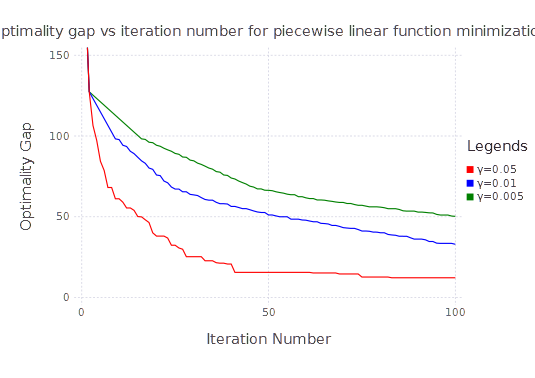

In [125]:
plot(
layer(x=itersSm,y=curveGamma1,Geom.line, Theme(default_color=color("red"))),
layer(x=itersSm,y=curveGamma2,Geom.line, Theme(default_color=color("blue"))),
layer(x=itersSm,y=curveGamma3,Geom.line, Theme(default_color=color("green"))),
Guide.manual_color_key("Legends", ["γ=0.05", "γ=0.01","γ=0.005"], [color("red"), color("blue"),color("green")]),
Guide.ylabel("Optimality Gap"), # label for y-axis
Guide.xlabel("Iteration Number"),  # label for x-axis
Guide.title("Optimality gap vs iteration number for piecewise linear function minimization"),  # a title
)

Now let us plot the same curves for 3000 iterations. 

In [126]:
#fig3000itrs = FramedPlot(
#title="The value of f_{best}^{(k)} - f^{*} vs. iteration number k=1,...,3000 for constant step length",
#         xlabel="k",
#         ylabel="f_{best}^{(k)} - f^{*}",
#yrange=(1e-2,2),
#ylog=true
#)
#xAxis=iters
#curveGamma1=fBest1-fMinValue # This is the curve of f_{best}^{(k)} - f^{*} for gamma = 0.05
#curveGamma2=fBest2-fMinValue # This is the curve of f_{best}^{(k)} - f^{*} for gamma = 0.01
#curveGamma3=fBest3-fMinValue # This is the curve of f_{best}^{(k)} - f^{*} for gamma = 0.005
#re=Curve(xAxis, curveGamma1, color="red")
#setattr(re, label="γ=0.05")
#gr=Curve(xAxis, curveGamma2, color="green")
#setattr(gr, label="γ=0.01")
#bl=Curve(xAxis, curveGamma3, color="blue")
#setattr(bl, label="γ=0.005")
#le=Legend(.03,.2,{re,gr,bl})
#add(fig3000itrs,re,gr,bl,le)

In [127]:
iters=[1:maxIter]
curveGammaFl1=abs((fBest1-fMinValue)/fMinValue)*100 # This is the optimality gap for gamma = 0.05
curveGammaFl2=abs((fBest2-fMinValue)/fMinValue)*100 # This is the optimality gap for gamma = 0.01
curveGammaFl3=abs((fBest3-fMinValue)/fMinValue)*100 # This is the optimality gap for gamma = 0.005

3000-element Array{Float64,1}:
 Inf      
 127.37   
 125.289  
 123.207  
 121.126  
 119.044  
 116.963  
 114.882  
 112.8    
 110.719  
 108.638  
 106.556  
 104.475  
   ⋮      
   1.53927
   1.53927
   1.53927
   1.53927
   1.53927
   1.53927
   1.53927
   1.53927
   1.53927
   1.53927
   1.53927
   1.53927

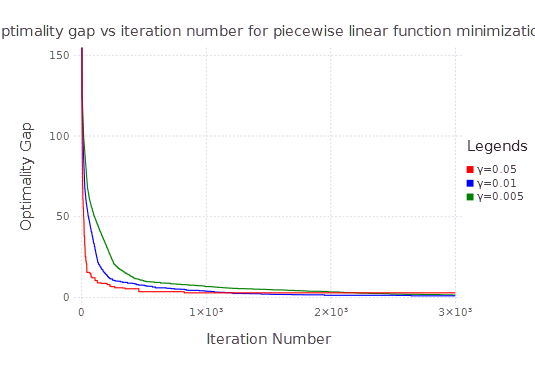

In [128]:
plot(
layer(x=iters,y=curveGammaFl1,Geom.line, Theme(default_color=color("red"))),
layer(x=iters,y=curveGammaFl2,Geom.line, Theme(default_color=color("blue"))),
layer(x=iters,y=curveGammaFl3,Geom.line, Theme(default_color=color("green"))),
Guide.manual_color_key("Legends", ["γ=0.05", "γ=0.01","γ=0.005"], [color("red"), color("blue"),color("green")]),
Guide.ylabel("Optimality Gap"), # label for y-axis
Guide.xlabel("Iteration Number"),  # label for x-axis
Guide.title("Optimality gap vs iteration number for piecewise linear function minimization"),  # a title
)

## Implementing subgradient method for diminishing step rule and square summable step size rule
For these two step rules $f_\textrm{best}^{(k)}-f^*$ converges to zero, so we will not calculate the lower bound in these cases. Unlike the constant step length case, we do not attempt to find any optimal soution. We just see how far subgradient method can take us.
### The diminishing step rule
These step rules satisfy

\begin{align}
\alpha_{k} \geq 0, \quad \lim_{k \to \infty}{\alpha_{k}}=0, \quad \sum_{k=1}^{\infty}{\alpha_{k}}=\infty.
\end{align}

For example, $\alpha_{k}=\frac{a}{\sqrt{k}}$, where $a >0$. In our code we will try $a=0.1$ and $a=1$.

### Square summable but not summable step size rule
These ones satisfy

\begin{align}
\alpha_{k} \geq 0, \quad \sum_{k=1}^{\infty}{\alpha_{k}^{2}} < \infty, \quad \sum_{k=1}^{\infty}{\alpha_{k}}=\infty.
\end{align}

A common example is $\alpha_{k}=\frac{a}{b+k}$, where $a > 0$ and $b \geq 0$. We will try $a=1$ and $a= 10$ with $b=0$.

Let's write the function for diminishing step rule first.

In [129]:
function sgm_pwl_nonsum_dimin(
    A::Array{Float64,2}, 
    b::Array{Float64,2}, 
    x1::Array{Float64,2}, 
    a::Float64, 
    maxIter::Int64
    )

fSet=Float64[] # We are creating an empty array where we will store the objective values as we progress
push!(fSet,Inf) # Intial value of f is infinity

fBest=Float64[] # It is an array where the last element will give f_best^{(k)} so far
push!(fBest, Inf) # Intial best value of f is infinity

k=1 # iteration index

x=x1 # assigning into x the starting value of x^(1)

while k < maxIter
# Finding one subgradient
fKval=maximum(A*x-b)
indActvf=indmax(A*x-b)
gk=A[indActvf,:]'
  
#Step size selection
alphak=a/sqrt(k)  
  
# Push the current value of f(x^(k)) in fSet
push!(fSet,fKval)

# Note how we are pushing the best f found so far in the last element of f
push!(fBest, min(fBest[end],fKval)) 

#update x
x=x-alphak*gk
#increase k by 1 
k=k+1
end # end while

return x, fSet, fBest

end

sgm_pwl_nonsum_dimin (generic function with 1 method)

Now let's write the function for square summable but not summable step sizes.

In [130]:
function sgm_pwl_sqrsum_nonsum(
    A::Array{Float64,2}, 
    b::Array{Float64,2}, 
    x1::Array{Float64,2}, 
    a::Float64, 
    maxIter::Int64
    )

fSet=Float64[] # We are creating an empty array where we will store the objective values as we progress
push!(fSet,Inf) # Intial value of f is infinity

fBest=Float64[] # It is an array where the last element will give f_best^{(k)} so far
push!(fBest, Inf) # Intial best value of f is infinity

k=1 # iteration index

x=x1 # assigning into x the starting value of x^(1)

while k < maxIter
# Finding one subgradient
fKval=maximum(A*x-b)
indActvf=indmax(A*x-b)
gk=A[indActvf,:]'
  
#Step size selection
alphak=a/k  
  
# Push the current value of f(x^(k)) in fSet
push!(fSet,fKval)

# Note how we are pushing the best f found so far in the last element of f
push!(fBest, min(fBest[end],fKval)) 

#update x
x=x-alphak*gk
#increase k by 1 
k=k+1
end # end while

return x, fSet, fBest

end

sgm_pwl_sqrsum_nonsum (generic function with 1 method)

Let's run the functions for different values.

In [131]:
(xNd1, fNd1, fBestNd1)=sgm_pwl_nonsum_dimin(A, b, x1, 0.1 , maxIter)
(xNd2, fNd2, fBestNd2)=sgm_pwl_nonsum_dimin(A, b, x1, 1.0 , maxIter)
(xSn1, fSn1, fBestSn1)=sgm_pwl_sqrsum_nonsum(A, b, x1, 1.0 , maxIter)
(xSn2, fSn2, fBestSn2)=sgm_pwl_sqrsum_nonsum(A, b, x1, 10.0 , maxIter)

(
20x1 Array{Float64,2}:
 -0.0751642
  0.291447 
  0.0937692
  0.319503 
  0.25848  
 -0.0381265
  0.0443182
  0.0171382
  0.142012 
  0.071316 
 -0.445098 
  0.226489 
 -0.0610694
  0.331841 
 -0.0234375
  0.385362 
  0.168615 
 -0.0521375
 -0.0774862
 -0.244811 ,

[Inf,2.8144,135.564,101.359,110.489,72.6825,66.2376,57.804,42.9065,37.5707  …  1.26004,1.28104,1.28921,1.26501,1.27033,1.27344,1.27552,1.25707,1.26895,1.25832],[Inf,2.8144,2.8144,2.8144,2.8144,2.8144,2.8144,2.8144,2.8144,2.8144  …  1.25108,1.25108,1.25108,1.25108,1.25108,1.25108,1.25108,1.25108,1.25108,1.25108])

Plotting time!

In [132]:
#figNdSn = FramedPlot(
#title="The value of f_{best}^{(k)} - f^{*} vs. iteration number for 
#       diminishing and square summable step size rule",
#         xlabel="k",
#        ylabel="f_{best}^{(k)} - f^{*}",
#yrange=(1e-3,1e1),
#ylog=true
#)
#xAxis=iters
#curveNd1=fBestNd1-fMinValue 
#curveNd2=fBestNd2-fMinValue 
#curveSn1=fBestSn1-fMinValue
#curveSn2=fBestSn2-fMinValue
#bl=Curve(xAxis, curveNd1, color="blue")
#setattr(bl, label="0.1/√k")
#gr=Curve(xAxis, curveNd2, color="green")
#setattr(gr, label="1/√k")
#re=Curve(xAxis, curveSn1, color="red")
#setattr(re, label="1/k")
#blk=Curve(xAxis, curveSn2, color="black")
#setattr(blk, label="10/k")
#le=Legend(.8,.95,{bl,gr,re,blk})
#add(figNdSn,bl,gr,re,blk,le)

In [133]:
curveNd1=abs((fBestNd1-fMinValue)/fMinValue)*100
curveNd2=abs((fBestNd2-fMinValue)/fMinValue)*100
curveSn1=abs((fBestSn1-fMinValue)/fMinValue)*100
curveSn2=abs((fBestSn2-fMinValue)/fMinValue)*100

3000-element Array{Float64,1}:
 Inf      
 127.37   
 127.37   
 127.37   
 127.37   
 127.37   
 127.37   
 127.37   
 127.37   
 127.37   
 127.37   
 127.37   
 127.37   
   ⋮      
   1.07218
   1.07218
   1.07218
   1.07218
   1.07218
   1.07218
   1.07218
   1.07218
   1.07218
   1.07218
   1.07218
   1.07218

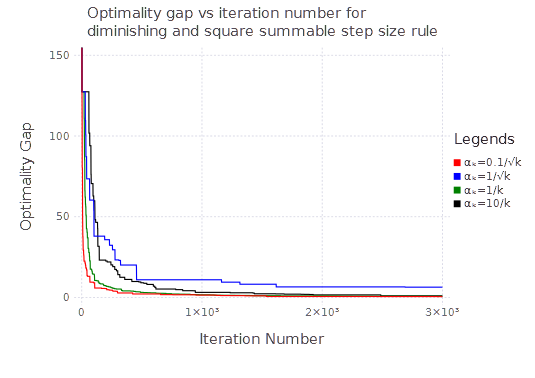

In [134]:
plot(
layer(x=iters,y=curveNd1,Geom.line, Theme(default_color=color("red"))),
layer(x=iters,y=curveNd2,Geom.line, Theme(default_color=color("blue"))),
layer(x=iters,y=curveSn1,Geom.line, Theme(default_color=color("green"))),
layer(x=iters,y=curveSn2,Geom.line, Theme(default_color=color("black"))),
Guide.manual_color_key("Legends", ["αₖ=0.1/√k", "αₖ=1/√k","αₖ=1/k","αₖ=10/k"], 
                      [color("red"), color("blue"),color("green"),color("black")]),
Guide.ylabel("Optimality Gap"), # label for y-axis
Guide.xlabel("Iteration Number"),  # label for x-axis
Guide.title("Optimality gap vs iteration number for 
diminishing and square summable step size rule"),  # a title
)

## Imeplementing subgradient methods using Polyak's step length
### Polyak's step length when $f^*$ is known
If $f^*$ is known, then we can use Polyak's step size, which is
$$
\alpha_k=\frac{f(x^{(k)})-f^*}{\|g^{(k)}\|_2^2}.
$$
As before, we will write a function that will implement subgradient method with Polyak's step length. We will compare the performance with diminishing step rule and square summable but not summable step rule.

In [135]:
function sgm_pwl_optimal_step(
                              A::Array{Float64,2},
                              b::Array{Float64,2}, 
                              x1::Array{Float64,2},
                              fMin::Float64, 
                              maxIter::Int64
                              )

fSet=Float64[] # We are creating an empty array where we will store the objective values as we progress
push!(fSet,Inf) # Intial value of f is infinity

fBest=Float64[] # It is an array where the last element will give f_best^{(k)} so far
push!(fBest, Inf) # Intial best value of f is infinity

k=1 # iteration index

x=x1 # assigning into x the starting value of x^(1)

while k < maxIter
# Finding one subgradient
fKval=maximum(A*x-b)
indActvf=indmax(A*x-b)
gk=A[indActvf,:]'
  
#Step size selection
alphak=(fKval-fMin)/norm(gk)^2  
  
# Push the current value of f(x^(k)) in fSet
push!(fSet,fKval)

# Note how we are pushing the best f found so far in the last element of f
push!(fBest, min(fBest[end],fKval)) 

#update x
x=x-alphak*gk
#increase k by 1 
k=k+1
end # end while

return x, fSet, fBest

end

sgm_pwl_optimal_step (generic function with 1 method)

In [136]:
(xPol, fPol, fBestPol)=sgm_pwl_optimal_step(A, b, x1, fMinValue , maxIter)


(
20x1 Array{Float64,2}:
 -0.0771357
  0.252636 
  0.0884199
  0.297006 
  0.277788 
 -0.0428087
  0.0639865
  0.0227537
  0.131011 
  0.116207 
 -0.421202 
  0.169591 
 -0.0235598
  0.310095 
  0.0102659
  0.36329  
  0.141078 
  0.0100246
 -0.0903456
 -0.20281  ,

[Inf,2.8144,2.38275,2.2631,2.17982,2.13807,1.99502,1.70523,1.66813,1.69508  …  1.25225,1.25125,1.25525,1.25021,1.25287,1.25244,1.25735,1.25151,1.25381,1.25469],[Inf,2.8144,2.38275,2.2631,2.17982,2.13807,1.99502,1.70523,1.66813,1.66813  …  1.24803,1.24803,1.24803,1.24803,1.24803,1.24803,1.24803,1.24803,1.24803,1.24803])

In [137]:
#figPolNdSn = FramedPlot(
#title="The value of f_{best}^{(k)} - f^{*} vs. iteration number for Polyak's step length",
#         xlabel="k",
#         ylabel="f_{best}^{(k)} - f^{*}",
#yrange=(1e-3,1e1),
#ylog=true
#)
#xAxis=iters
#curvePol=fBestPol-fMinValue
#curveNd1=fBestNd1-fMinValue 
#curveNd2=fBestNd2-fMinValue 
#curveSn1=fBestSn1-fMinValue
#curveSn2=fBestSn2-fMinValue
#cn=Curve(xAxis, curvePol, color="cyan")
#setattr(cn, label="Polyak's step length")
#bl=Curve(xAxis, curveNd1, color="blue")
#setattr(bl, label="0.1/sqrt(k)")
#gr=Curve(xAxis, curveNd2, color="green")
#setattr(gr, label="1/√k")
#re=Curve(xAxis, curveSn1, color="red")
#setattr(re, label="1/k")
#blk=Curve(xAxis, curveSn2, color="black")
#setattr(blk, label="10/k")
#le=Legend(.7,.9,{cn,bl,re})
#add(figPolNdSn, cn, bl,re, le)

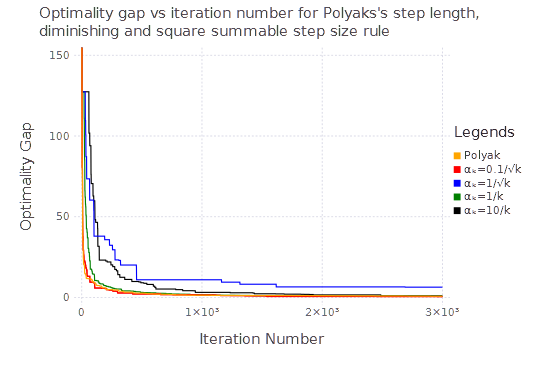

In [138]:
curvePol=abs((fBestPol-fMinValue)/fMinValue)*100
plot(
layer(x=iters,y=curvePol,Geom.line, Theme(default_color=color("orange"))),
layer(x=iters,y=curveNd1,Geom.line, Theme(default_color=color("red"))),
layer(x=iters,y=curveNd1,Geom.line, Theme(default_color=color("red"))),
layer(x=iters,y=curveNd2,Geom.line, Theme(default_color=color("blue"))),
layer(x=iters,y=curveSn1,Geom.line, Theme(default_color=color("green"))),
layer(x=iters,y=curveSn2,Geom.line, Theme(default_color=color("black"))),
Guide.manual_color_key("Legends", ["Polyak","αₖ=0.1/√k", "αₖ=1/√k","αₖ=1/k","αₖ=10/k"], 
[color("orange"),color("red"), color("blue"),color("green"),color("black")]),
Guide.ylabel("Optimality Gap"), # label for y-axis
Guide.xlabel("Iteration Number"),  # label for x-axis
Guide.title("Optimality gap vs iteration number for Polyaks's step length, 
diminishing and square summable step size rule"),  # a title
)

In conclusion, we can say that no matter how cleverly we choose the step size, the subgradient method does not seem to improve significantly, it is structurally slow.